# Issues need to be solved:
1. Potential array interpolation.

    For a 3-dimensional interpolation, there could be also **_nearest_, _linear_ and _cubic_** methods. [Wiki on multivariate interpolation.](https://en.wikipedia.org/wiki/Interpolation)  [Scipy.interpolate](https://docs.scipy.org/doc/scipy-0.18.1/reference/interpolate.html) provides several functions for high dimension interpolation. [RegularGridInterpolation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.RegularGridInterpolator.html#scipy.interpolate.RegularGridInterpolator) only provides linear and nearest methods, which might be insufficient for our field potential interpolation. [GridData function](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata) provides (1-d or 2-d) cubic interpolation, which might match our request.
    
2. Units.

    In the trajectory calculation, length in unit of mm, time in unit of us, velocity in unit of mm/us, charge in unit of e, mass in unit of 
    
3. Trajectories iteration or 2nd [ODE solution](https://docs.scipy.org/doc/scipy-0.13.0/reference/integrate.html)
    
    [ode](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode)
    
    [odein](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.integrate.odeint.html)
    
    Vector function integration using [Runge-Kutta methods](https://rosettacode.org/wiki/Runge-Kutta_method) or Euler
    Should the gradient force be calculated everytime iteration is made or should it be calculated at once.
    
    
## To-Do
1. Integration method problem. [Change iteration algorithms](http://stackoverflow.com/questions/19779217/need-help-solving-a-second-order-non-linear-ode-in-python)
Runge-Kutta method?

2. Interpolation and gradient calculation step.

3. Change electrodes potentials to the current setup. Single ion trajectory as function of time. in Runge-Kutta integration.

4. Simulate detected signal.

5. Time resolution

6. Define MCP detection area and ion stop condition

Note: 11.08: When doing Gradient/Electric force calculation, spatial step is important

### Import potentials and coordinates from HDF5 file

In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
#Potential field are stored in a HDF5 file
f=h5py.File('PA_v4.hdf5','r')

In [4]:
for name in f:
    print(name)

Coordinates
Potential Arrays
iselectrode


In [5]:
#coordinates x,y,z in unit of mm
x=f["Coordinates/X"].value/2.
y=f["Coordinates/Y"].value/2.
z=f["Coordinates/Z"].value/2.

### Set electrodes potentials and calculate spatial potential values
19 electrodes are set to certain potentials to create electric field to ionize Rydberg atoms

In [6]:
#set values of 19 electrodes, for ionization field of state n=30
electrode_set_potentials=[1010.,1010.,-1090.,-1000.,-50.,-2000.,0.,100.,900.,-1700.,1010.,1010.,-1090.,-1000.,0.,0.,0.,0.,0.];

In [7]:
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
potentials=np.zeros((len(x),len(y),len(z)))
for i in range(19):
    electroden=f["Potential Arrays/electrode"+str(i+1)].value
    potentials+=electrode_set_potentials[i]*electroden/10000.

### Interpolate potential arrays and plot cross sections for comparison

In [8]:
#generate potential interpolation

from scipy.interpolate import RegularGridInterpolator as rgi
p_interpolation=rgi((x,y,z),potentials)

In [9]:
nx=np.arange(min(x),max(x),0.2)
nz=np.arange(min(z),max(z),0.2)
ny=(max(y)+min(y))/2.
X,Z=np.meshgrid(nx,nz,indexing='ij')
Y=ny
nx.shape,X.shape,nz.shape,Z.shape

((300,), (300, 430), (430,), (300, 430))

In [10]:
interpY_p=np.zeros((len(nx),len(nz)))
for i in range(len(nx)):
    for j in range(len(nz)):
        interpY_p[i,j]=p_interpolation([nx[i],ny,nz[j]])[0]

<IPython.core.display.Javascript object>


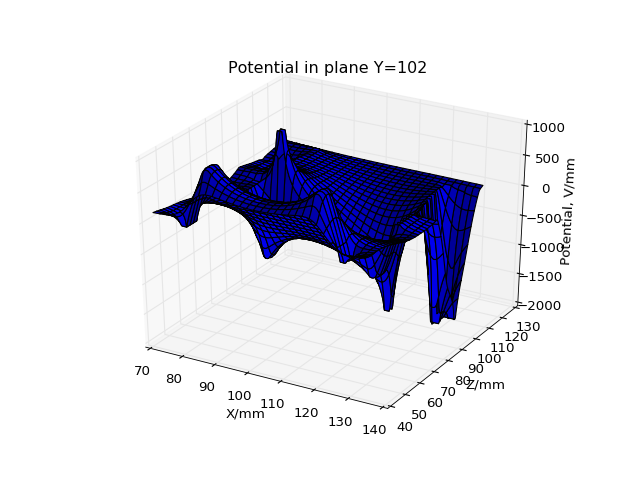

In [11]:
%matplotlib notebook
fig1=plt.figure()
surf=plt.subplot(111,projection='3d')
surf.plot_surface(X,Z,interpY_p)
surf.set_xlabel("X/mm")
surf.set_ylabel("Z/mm")
surf.set_zlabel("Potential, V/mm")
plt.title("Potential in plane Y=102")
plt.show()

<IPython.core.display.Javascript object>


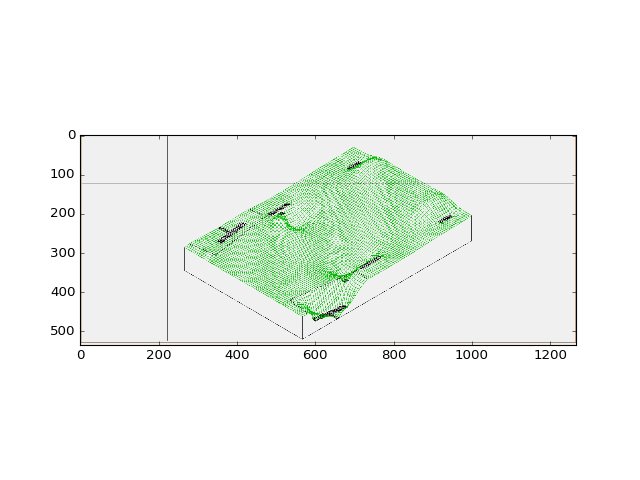

In [12]:
from PIL import Image as im
simion_surface=im.open('./Plot comparison/Simion potential surface n=30.PNG')
plt.imshow(simion_surface)

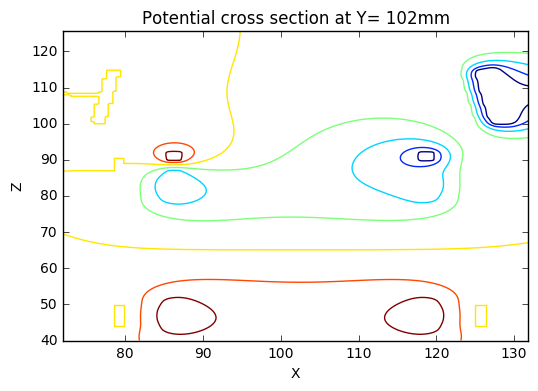

In [13]:
%matplotlib inline
plt.contour(X,Z,interpY_p)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Potential cross section at Y= 102mm")
plt.show()

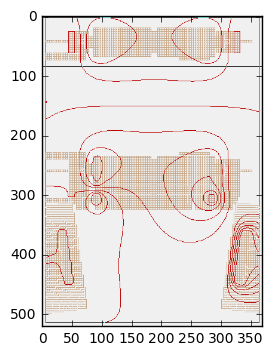

In [14]:
#load SIMION potential contour and surface plot of Y=102mm
simion_contour=im.open('./Plot comparison/Simion potential contour n=30.PNG')
plt.imshow(simion_contour)

In [15]:
ny=np.arange(90,111,0.2)
nz=np.arange(63,126,0.2)
nx=102.5
Y,Z=np.meshgrid(ny,nz,indexing='ij')
X=102.5
X

102.5

In [16]:
interpX_p=np.zeros((len(ny),len(nz)))
ij=np.meshgrid
for i in range(len(ny)):
    for j in range(len(nz)):
        interpX_p[i,j]=p_interpolation([nx,ny[i],nz[j]])[0]

<IPython.core.display.Javascript object>


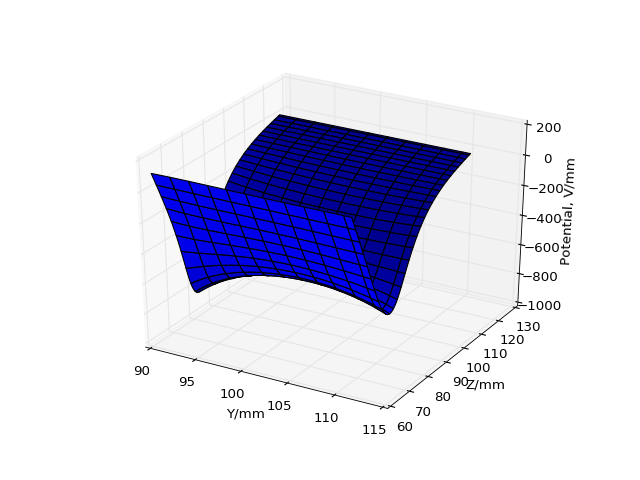

In [17]:
%matplotlib notebook
figX=plt.figure()
bx=plt.subplot(111,projection='3d')
bx.plot_surface(Y,Z,interpX_p)
bx.set_xlabel("Y/mm")
bx.set_ylabel("Z/mm")
bx.set_zlabel("Potential, V/mm")
plt.show()

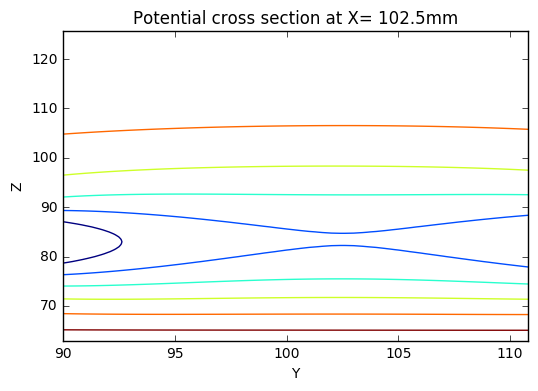

In [18]:
%matplotlib inline
plt.contour(Y,Z,interpX_p)
plt.xlabel("Y")
plt.ylabel("Z")
plt.title("Potential cross section at X= 102.5mm")
plt.show()

### Calculate single ion trajectory

Define velocity iteration function and trajectory iteration function for single ion.

In [19]:
#single ion's position and velocity iteration functions

def R(ri,vi,dt):                  #delta_t in unit of micro-second, displacement in unit of mm, v in unit of mm/us
    x_new=ri[0]+vi[0]*dt
    y_new=ri[1]+vi[1]*dt
    z_new=ri[2]+vi[2]*dt
    return np.array([x_new,y_new,z_new])

def v(ri,vi,delta_t,dr):
    dvx=-100./(1.0364*87.) * (p_interpolation([ri[0]+dr,ri[1],ri[2]])[0]-p_interpolation([ri[0]-dr,ri[1],ri[2]])[0])/(dr*2) #- for positive ions, + for electrons
    dvy=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1]+dr,ri[2]])[0]-p_interpolation([ri[0],ri[1]-dr,ri[2]])[0])/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1],ri[2]+dr])[0]-p_interpolation([ri[0],ri[1],ri[2]-dr])[0])/(dr*2)
    vx_new=vi[0]+dvx * dt
    vy_new=vi[1]+dvy * dt
    vz_new=vi[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])

In [20]:
#Starting point r0 and initial velocity v0
r0=[102.5,102.5,65]
v0=[0,0,0]

**Distance step when calculating gradient has significant fluence on the trajectories**

In [21]:
dr=0.5       #dr[mm] is used when calculating gradients
dt=0.001     #dt[us]

In [22]:
"""
v_iter=np.zeros((2000,3))
r_iter=np.zeros((2000,3))
r_iter[0]=r0
v_iter[0]=v0
for i in range(1999):
    v_iter[i+1]=v(r_iter[i],v_iter[i],dt,dr)
    r_iter[i+1]=R(r_iter[i],v_iter[i+1],dt)

%matplotlib inline
trj1=plt.figure()
ax=trj1.add_subplot(111,projection='3d')
xt=r_iter[:,0]
yt=r_iter[:,1]
zt=r_iter[:,2]
ax.plot(xt,yt,zt)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


trj1xz=plt.figure()
xt=r_iter[:,0]
yt=r_iter[:,1]
zt=r_iter[:,2]
plt.plot(xt,zt)
plt.xlabel("X")
plt.ylabel("Z")
plt.show()

"""

'\nv_iter=np.zeros((2000,3))\nr_iter=np.zeros((2000,3))\nr_iter[0]=r0\nv_iter[0]=v0\nfor i in range(1999):\n    v_iter[i+1]=v(r_iter[i],v_iter[i],dt,dr)\n    r_iter[i+1]=R(r_iter[i],v_iter[i+1],dt)\n\n%matplotlib inline\ntrj1=plt.figure()\nax=trj1.add_subplot(111,projection=\'3d\')\nxt=r_iter[:,0]\nyt=r_iter[:,1]\nzt=r_iter[:,2]\nax.plot(xt,yt,zt)\nplt.xlabel("X")\nplt.ylabel("Y")\nplt.show()\n\n\ntrj1xz=plt.figure()\nxt=r_iter[:,0]\nyt=r_iter[:,1]\nzt=r_iter[:,2]\nplt.plot(xt,zt)\nplt.xlabel("X")\nplt.ylabel("Z")\nplt.show()\n\n'

In [23]:
v_iter=np.zeros((1,3))
r_iter=np.zeros((1,3))
r_iter[0]=r0
v_iter[0]=v0
while (r_iter[-1]>[x[0],y[0],z[0]]).all and (r_iter[-1]<[x[-1],y[-1],z[-1]]).all() and (r_iter[-1][2]+11*r_iter[-1][0]<=1499):
    v_iter=np.append(v_iter,[v(r_iter[-1],v_iter[-1],dt,dr)],0)
    r_iter=np.append(r_iter,[R(r_iter[-1],v_iter[-1],dt)],0)

In [24]:
#import simion simulated single ion trajectory
simion_trajectory=pd.read_csv('./flying ion test v2.csv',header=None)

simion_trajectory.columns=['TOF','x','y','z','vx','vy','vz']
sim_x=simion_trajectory.x.values
sim_y=simion_trajectory.y.values
sim_z=simion_trajectory.z.values

**Problem: There is an obvious deviation between the Python calculated trajectory and the SIMION result.**
Possible reason: 1. Potential interpolation, 2. Trajectory iteration

<IPython.core.display.Javascript object>


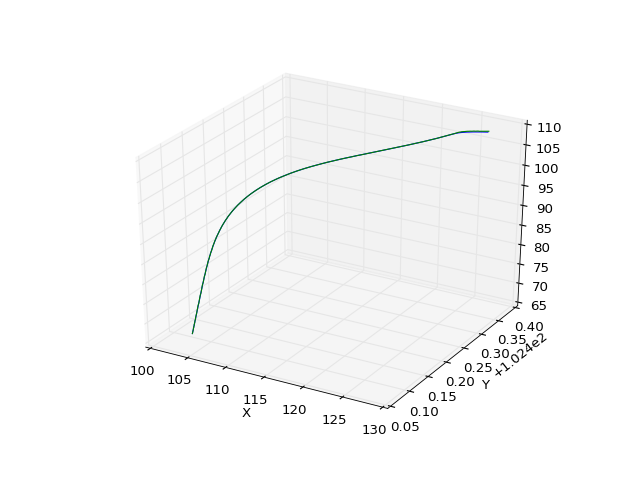

In [25]:
%matplotlib notebook
trj3d=plt.figure()
ax=trj3d.add_subplot(111,projection='3d')
xt=r_iter[:,0]
yt=r_iter[:,1]
zt=r_iter[:,2]
ax.plot(xt,yt,zt)
ax.plot(sim_x,sim_y,sim_z)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

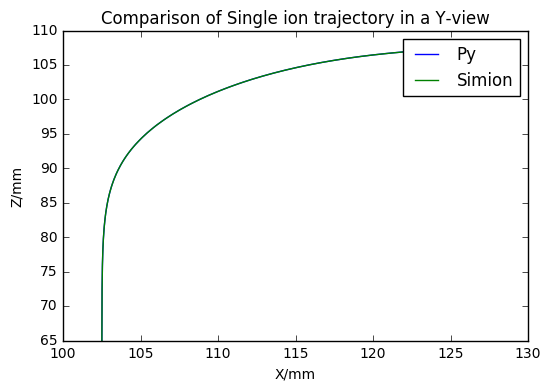

In [26]:
%matplotlib inline
trj2=plt.figure()
xt=r_iter[:,0]
yt=r_iter[:,1]
zt=r_iter[:,2]
plt.plot(xt,zt,label="Py")
plt.plot(sim_x,sim_z,label="Simion")
plt.title("Comparison of Single ion trajectory in a Y-view")
plt.xlabel("X/mm")
plt.ylabel("Z/mm")
plt.legend()
plt.show()

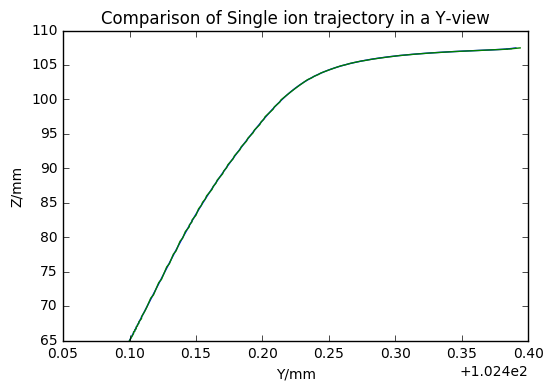

In [27]:
trj3=plt.figure()
plt.plot(yt,zt,label="Py")
plt.plot(sim_y,sim_z,label="Simion")
plt.title("Comparison of Single ion trajectory in a Y-view")
plt.xlabel("Y/mm")
plt.ylabel("Z/mm")
#plt.legend()
plt.show()

In [28]:
r_iter[-1],v_iter[-1]

(array([ 126.52150501,  102.79075931,  107.46110422]),
 array([ 65.08401569,   0.26433652,   6.16123012]))